In [1]:
import joblib, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, json
os.makedirs('config/', exist_ok=True)

# organize files into three folders(data, models, images)
FPATHS = {
'data': {'tf': {'train_tf': 'data/training_tf', 'test_tf': 'data/testing_tf'}},
'models': {'gru': 'models/tf/'},
'images': {'scattertext': 'images/scattertext.html'}
}

In [2]:
def create_directories_from_paths(nested_dict):
    for key, value in nested_dict.items():
        if isinstance(value, dict):
            # If the value is a dictionary, recurse into it
            create_directories_from_paths(value)
        elif isinstance(value, str):
            # If the value is a string, treat it as a file path and get the directory path
            directory_path = os.path.dirname(value)
            # If the directory path is not empty and the directory does not exist, create it
            if directory_path and not os.path.exists(directory_path):
                os.makedirs(directory_path)
                print(f"Directory created: {directory_path}")

# Use the function on your FPATHS dictionary
create_directories_from_paths(FPATHS)

Directory created: models/tf


In [3]:
#  loading it back in 
loaded = joblib.load('Data/movie_reviews_v2.joblib')
df = loaded['df']

In [4]:
highrate= df['rating']>=9
lowrate= df['rating']<=4
df.loc[highrate,'High_Low']='high'
df.loc[lowrate,'High_Low']='low'
df.head()

,movie_id,imdb_id,original_title,review,rating,tokens,lemmas,tokens-joined,lemmas-joined,High_Low
review_id,,,,,,,,,,
57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,"[guilty, pleasure, personally, love, great, es...","[guilty, pleasure, personally, love, great, es...",guilty pleasure personally love great escape w...,guilty pleasure personally love great escape w...,high
57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,"[underwhelmed, straight, bored, course, seeing...","[underwhelme, straight, bore, course, see, hun...",underwhelmed straight bored course seeing hunt...,underwhelme straight bore course see hunt clim...,low
5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,"[entertainign, mission, impossible, second, in...","[entertainign, mission, impossible, second, in...",entertainign mission impossible second install...,entertainign mission impossible second install...,low
608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,"[okay, admit, bit, easy, grader, comes, romant...","[okay, admit, bit, easy, grader, come, romanti...",okay admit bit easy grader comes romantic come...,okay admit bit easy grader come romantic comed...,high
6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,"[scream, 3, lackluster, screenplay, unimaginat...","[scream, 3, lackluster, screenplay, unimaginat...",scream 3 lackluster screenplay unimaginative k...,scream 3 lackluster screenplay unimaginative k...,low


In [5]:
X=df['review']
y=df['High_Low']
y.value_counts(normalize=True)

low     0.508772
high    0.491228
Name: High_Low, dtype: float64

In [6]:
from sklearn.preprocessing import LabelEncoder

# Instansiate label encoder
encoder = LabelEncoder()
# Fit and Transform the strings into integers
y = encoder.fit_transform(y)
# Original Class names saved as .classes_
classes = encoder.classes_
y[:10], classes

(array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1]), array(['high', 'low'], dtype=object))

In [7]:
# Get the encoded values for each both classes
class_codes = encoder.transform(classes)
# Making lookup dictionary to find the encoded label's original name
target_lookup = dict(zip(class_codes, classes))
target_lookup

{0: 'high', 1: 'low'}

In [8]:
# estimate sequence length
df['length (tokens)'] = df['tokens'].map(len)
df['length (tokens)'].describe()

count    2394.000000
mean      104.807435
std       129.819129
min         1.000000
25%        29.000000
50%        67.000000
75%       130.000000
max      1937.000000
Name: length (tokens), dtype: float64

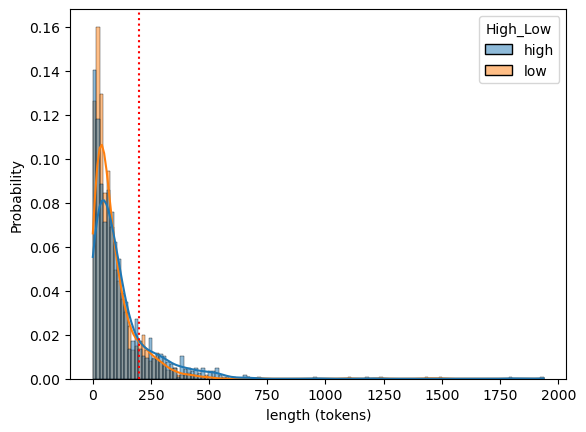

In [9]:
SEQUENCE_LENGTH = 200
ax = sns.histplot(data=df, hue='High_Low', x='length (tokens)', kde=True,
                 stat='probability',common_norm=False)
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":");

In [10]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs
    
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [11]:

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(4,8),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):

    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

## PLOT_HISTORY FUNCTION
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [12]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,6), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)       y_train (array, or None if using a Dataset)
        X_test (array, or Dataset)        y_test (array, or None if using a Dataset)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'shuffle'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
            ## Run model.evaluate         
            print("\n- Evaluating Training Data:")
            print(model.evaluate(X_train, return_dict=True))
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')

    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'shuffle'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
            ## Run model.evaluate         
            print("\n- Evaluating Test Data:")
            print(model.evaluate(X_test, return_dict=True))
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

# Select a sklearn vectorizer and Build Machine Learning Models

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Train test split for well balanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

In [14]:
# Create a pipeline with placeholders
clf_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',RandomForestClassifier())])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('clf', RandomForestClassifier())])


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       999
           1       1.00      1.00      1.00      1035

    accuracy                           1.00      2034
   macro avg       1.00      1.00      1.00      2034
weighted avg       1.00      1.00      1.00      2034



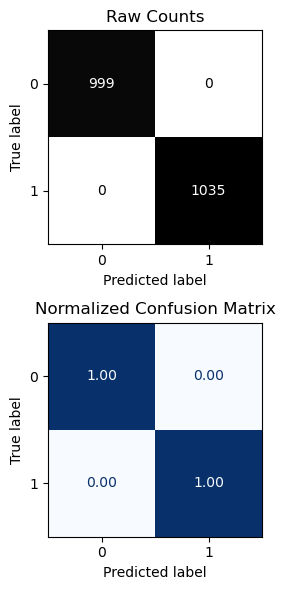

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       177
           1       0.88      0.75      0.81       183

    accuracy                           0.82       360
   macro avg       0.83      0.83      0.82       360
weighted avg       0.83      0.82      0.82       360



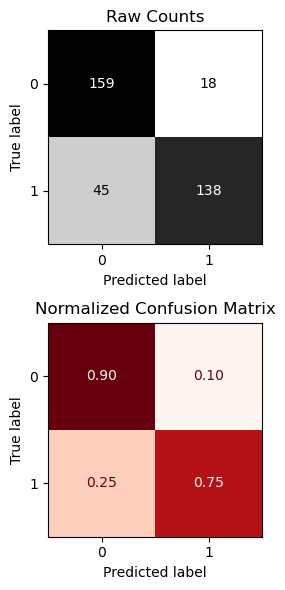

In [15]:
# Fit the model pipeline
clf_pipe.fit(X_train, y_train)
# Predict and Evaluate with the custom function
evaluate_classification_network(clf_pipe, X_train, y_train, X_test, y_test)

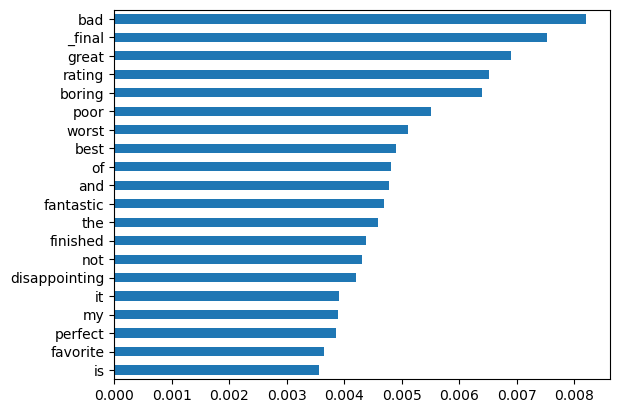

In [16]:
# Plot feature importances
importances = pd.Series(clf_pipe[-1].feature_importances_, 
                       index = clf_pipe[0].get_feature_names_out())
importances.sort_values().tail(20).plot(kind='barh');

# GridSearch Text Vectorization

In [17]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8],
    'vectorizer__min_df': [2, 3], 
    'vectorizer__ngram_range': [(1, 1), (2,2)],
    "vectorizer__max_features": [None, 1000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    **param_grid_shared
}

# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]

In [18]:
# Define parameters to tune multiple models

param_grid_RF = {
    'clf' : [RandomForestClassifier(random_state = 42)],
    'clf__max_depth' : [5, None],
}

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42)],
    'clf__C' : [.1, 1, 10],
}

# combine into list of params
model_params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]

In [19]:
import itertools

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
paired_param_grids[0]

({'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8],
  'vectorizer__min_df': [2, 3],
  'vectorizer__ngram_range': [(1, 1), (2, 2)],
  'vectorizer__max_features': [None, 1000],
  'vectorizer__stop_words': [None, 'english']},
 {'clf': [RandomForestClassifier(random_state=42)],
  'clf__max_depth': [5, None]})

In [20]:
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8],
 'vectorizer__min_df': [2, 3],
 'vectorizer__ngram_range': [(1, 1), (2, 2)],
 'vectorizer__max_features': [None, 1000],
 'vectorizer__stop_words': [None, 'english'],
 'clf': [RandomForestClassifier(random_state=42)],
 'clf__max_depth': [5, None]}

In [21]:
%%time
# Create grid search
grid_search = GridSearchCV(clf_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
    
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 672 candidates, totalling 2016 fits
CPU times: total: 38.3 s
Wall time: 11min 8s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [5, None],
                          'vectorizer': [CountVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8],
                          'vectorizer__max_features': [None, 1000],
                          'vectorizer__min_df': [2, 3],
                          'vectorizer...
                         {'clf': [LogisticRegression(C=10, random_state=42)],
                          'clf__C': [0.1, 1, 10],
                          'vectorizer': [TfidfVectorizer(max_df=0.7, min_df=2)],
                          'vectorizer__max_df': [0.7, 0.8],
                          'vectorizer__max_features': [None, 1000],
                          'vectorizer__min_df': [2, 3],
                          'vectorizer__ngram_range': [(1, 1), (2, 2)],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__stop_words': [None, 'english']}],
             scoring='accuracy', verbose=1)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       999
           1       1.00      1.00      1.00      1035

    accuracy                           1.00      2034
   macro avg       1.00      1.00      1.00      2034
weighted avg       1.00      1.00      1.00      2034



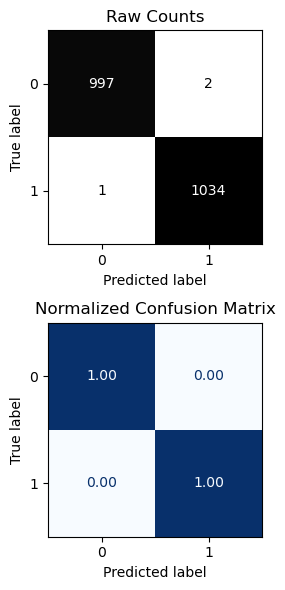

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       177
           1       0.89      0.89      0.89       183

    accuracy                           0.89       360
   macro avg       0.89      0.89      0.89       360
weighted avg       0.89      0.89      0.89       360



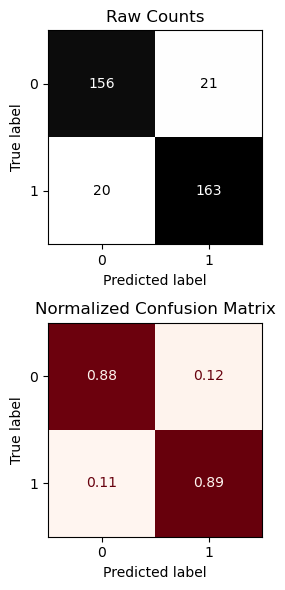

In [22]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification_network(best_model, X_train, y_train, X_test, y_test)

In [23]:
# Access the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'clf': LogisticRegression(C=10, random_state=42), 'clf__C': 10, 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=2), 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__stop_words': None}


In [26]:
# Saving train and test data in joblib files
joblib.dump([X_train, y_train], 'data/training-data.joblib')
joblib.dump([X_test, y_test], 'data/testing-data.joblib')
# ​Save encoder and dictionary
joblib.dump(encoder, 'data/label-encoder.joblib')
joblib.dump(target_lookup,'data/target-lookup-dict.joblib')
#Save best model pipeline
joblib.dump(best_model, 'models/best-pipe.joblib')

['models/best-pipe.joblib']

In [59]:
FPATHS = {
#########################################
'data': {'ml': {'train': 'data/training-data.joblib',
       'test': 'data/testing-data.joblib',
       'label_encoder': 'data/label-encoder.joblib',
       'target_lookup': 'data/target-lookup-dict.joblib'},
       'tf': {'train_ds': 'Data/tf/train/', 'test_ds': 'Data/tf/test/', 'val_ds': 'Data/tf/val/'},
       'raw': 'Data/movie_reviews_v2.csv',
       'processed': 'Data/movie_reviews_v2.joblib'},
#########################################
'models': {'ml': 'models/best-pipe.joblib',
           'deep': 'models/tf/'},
#########################################
'images': {'scattertext': 'images/scattertext.html',
  'wordclouds-raw': 'images/wordclouds-raw-text.png',
  'wordclouds-lemmas': 'images/wordclouds-lemmas.png'}
}

FPATHS_FILE = 'config/filepaths.json'
with open(FPATHS_FILE, 'w') as f:
    json.dump(FPATHS, f)

# Create train/test/val datasets

In [42]:
import tensorflow as tf
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
# Then Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [43]:
# Make a dataset object from train data
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Make a dataset object from test data
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle dataset
train_ds = train_ds.shuffle(buffer_size=len(train_ds),reshuffle_each_iteration=False) 
test_ds = test_ds.shuffle(buffer_size=len(test_ds),reshuffle_each_iteration=False) 
# display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"Arguably works as an example of the sort of red flags one might want to look out for if they suspect that a film's director is (like Brett Ratner) a sex offender.\r\n\r\nBut as a movie? Nah, not so much.\r\n\r\n_Final rating:\xe2\x98\x85 - Of no value. Avoid at all costs._", shape=(), dtype=string) 

 tf.Tensor(1, shape=(), dtype=int32)


In [44]:
# Set the ratio of the train, validation, test split
split_train = .75
split_val =  .25
# Calculate the number of samples for training and validation data 
n_train_samples = int(len(train_ds) * split_train)
n_val_samples = int(len(train_ds) * split_val)
n_test_samples = len(test_ds)

# Set the batch size
BATCH_SIZE =32
 
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	1525 samples 	(48 batches)
    - val:  	508 samples 	(16 batches)
    - test: 	360 samples 	(12 batches)


In [45]:
# Use take and skip to define each set
val_ds = train_ds.take(n_val_samples).batch(batch_size=BATCH_SIZE)
train_ds = train_ds.skip(n_val_samples).batch(batch_size=BATCH_SIZE)
# Put the test data into batches also
test_ds = test_ds.batch(batch_size = BATCH_SIZE)
# Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(48, 16, 12)

In [46]:
_, example_y= train_ds.take(1).get_single_element()
print(example_y)

tf.Tensor([0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0], shape=(32,), dtype=int32)


# Create a Keras Sequence Vectorizer layer

In [47]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH)

sequence_vectorizer.adapt(ds_texts)

In [48]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

23845

In [49]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'and',
 4: 'a',
 5: 'of',
 6: 'to',
 7: 'is',
 8: 'it',
 9: 'in',
 10: 'that',
 11: 'i',
 12: 'this',
 13: 'but',
 14: 'with',
 15: 'was',
 16: 'for',
 17: 'as',
 18: 'movie',
 19: 'film',
 20: 'not',
 21: 'are',
 22: 'on',
 23: 'its',
 24: 'you',
 25: 'be',
 26: 'one',
 27: 'have',
 28: 'his',
 29: 'so',
 30: 'an',
 31: 'like',
 32: 'he',
 33: 'all',
 34: 'from',
 35: 'they',
 36: 'at',
 37: 'by',
 38: 'just',
 39: 'if',
 40: 'about',
 41: 'what',
 42: 'or',
 43: 'more',
 44: 'has',
 45: 'story',
 46: 'there',
 47: 'some',
 48: 'even',
 49: 'who',
 50: 'good',
 51: 'my',
 52: 'me',
 53: 'out',
 54: 'really',
 55: 'very',
 56: 'when',
 57: 'we',
 58: 'no',
 59: 'which',
 60: 'time',
 61: 'well',
 62: 'can',
 63: 'had',
 64: 'only',
 65: 'than',
 66: 'much',
 67: 'their',
 68: 'up',
 69: 'would',
 70: 'her',
 71: 'also',
 72: 'because',
 73: 'into',
 74: 'do',
 75: 'way',
 76: 'how',
 77: 'most',
 78: 'character',
 79: 'great',
 80: 'characters',
 81:

# Build Deep Sequence Models (RNN)

In [50]:
from tensorflow.keras import layers, models, optimizers, callbacks
tf.keras.backend.clear_session()

def build_rnn_model1():
    EMBED_DIM=150
    model = models.Sequential([
        sequence_vectorizer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
    
    ## Add an LSTM layer with 32 units
    model.add(layers.LSTM(32, return_sequences = True))    
    # Add recurrent_dropout=0.2 to the SimpleRNN 
    model.add(layers.SimpleRNN(16))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate = .003), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model
    
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 150)          3576750   
                                                                 
 lstm (LSTM)                 (None, 200, 32)           23424     
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3,600,975
Trainable params: 3,600,975
Non-trainable params: 0
______________________________________________

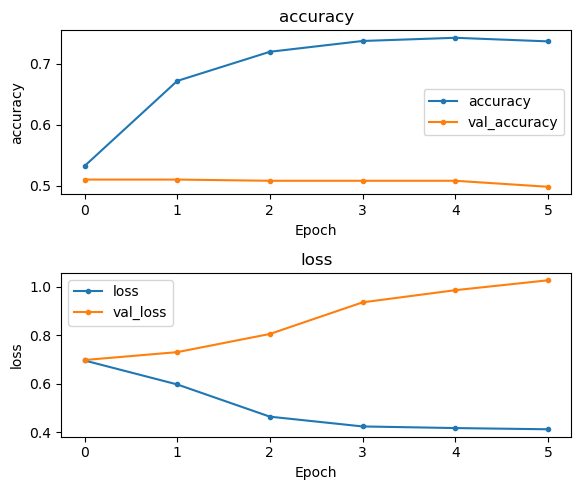

In [51]:
# Build the RNN model 
rnn_model1 = build_rnn_model1()

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model1.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
plot_history(history,figsize=(6,5))


- Evaluating Network...

- Evaluating Training Data:
48/48 [==============================] - 2s 33ms/step - loss: 0.4232 - accuracy: 0.7346
{'loss': 0.4231610596179962, 'accuracy': 0.7346002459526062}
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.45      0.62       724
           1       0.67      0.99      0.80       802

    accuracy                           0.73      1526
   macro avg       0.82      0.72      0.71      1526
weighted avg       0.81      0.73      0.71      1526



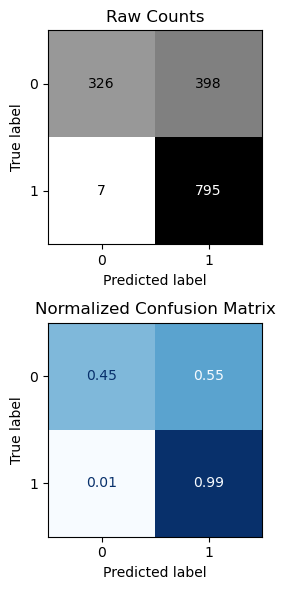


- Evaluating Test Data:
12/12 [==============================] - 0s 32ms/step - loss: 1.0493 - accuracy: 0.5250
{'loss': 1.0493063926696777, 'accuracy': 0.5249999761581421}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.20      0.30       177
           1       0.52      0.84      0.64       183

    accuracy                           0.53       360
   macro avg       0.53      0.52      0.47       360
weighted avg       0.53      0.53      0.47       360



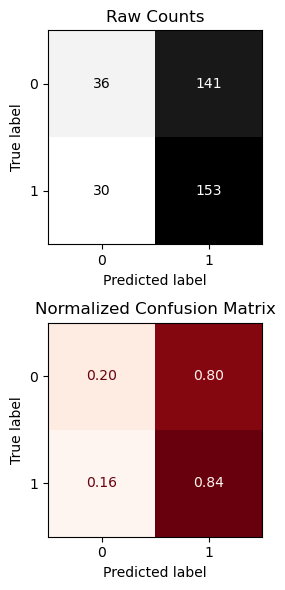

In [52]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    rnn_model1, X_train=train_ds, X_test=test_ds);

In [53]:
tf.keras.backend.clear_session()

def build_rnn_model2():
    EMBED_DIM=150
    model = models.Sequential([
        sequence_vectorizer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
    

    model.add(layers.LSTM(64, return_sequences = True))    
    model.add(layers.Dropout(.4))
    model.add(layers.GRU(32, return_sequences = True))
    model.add(layers.Dropout(.2))
    model.add(layers.GlobalMaxPooling1D())
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.Adamax(), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

# Build the RNN model 
rnn_model2 = build_rnn_model2()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 150)          3576750   
                                                                 
 lstm (LSTM)                 (None, 200, 64)           55040     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 gru (GRU)                   (None, 200, 32)           9408      
                                                                 
 dropout_1 (Dropout)         (None, 200, 32)           0         
                                                        

Epoch 1/30
48/48 [==============================] - 16s 260ms/step - loss: 0.6906 - accuracy: 0.5380 - val_loss: 0.6900 - val_accuracy: 0.5492
Epoch 2/30
48/48 [==============================] - 12s 250ms/step - loss: 0.6815 - accuracy: 0.5924 - val_loss: 0.6771 - val_accuracy: 0.6673
Epoch 3/30
48/48 [==============================] - 12s 248ms/step - loss: 0.5833 - accuracy: 0.7058 - val_loss: 0.5803 - val_accuracy: 0.7382
Epoch 4/30
48/48 [==============================] - 12s 245ms/step - loss: 0.4398 - accuracy: 0.8349 - val_loss: 0.5381 - val_accuracy: 0.7323
Epoch 5/30
48/48 [==============================] - 12s 241ms/step - loss: 0.2936 - accuracy: 0.9155 - val_loss: 0.6378 - val_accuracy: 0.6555
Epoch 6/30
48/48 [==============================] - 13s 262ms/step - loss: 0.2584 - accuracy: 0.9030 - val_loss: 0.5602 - val_accuracy: 0.7224
Epoch 7/30
48/48 [==============================] - 12s 242ms/step - loss: 0.1673 - accuracy: 0.9548 - val_loss: 0.5286 - val_accuracy: 0.7697

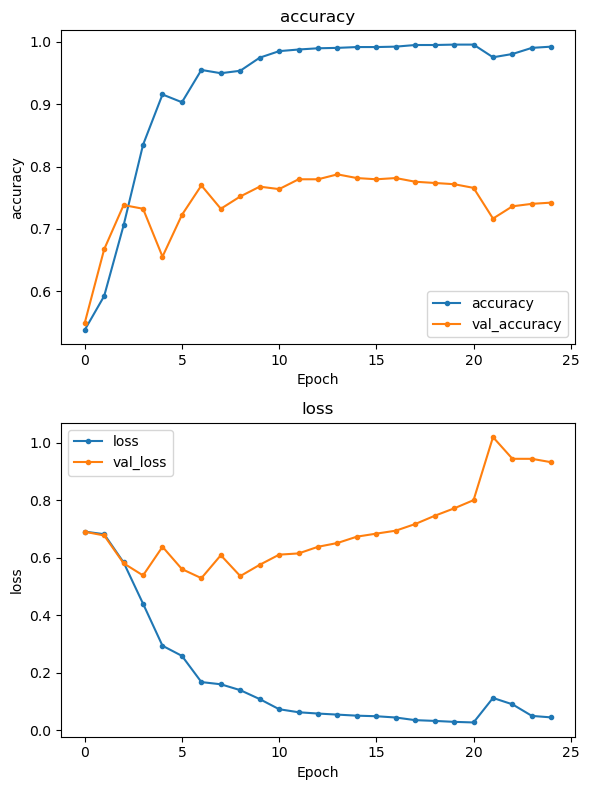

CPU times: total: 5min 22s
Wall time: 5min 2s


In [54]:
%%time
def get_callbacks(patience=3, monitor='accuracy'):
    early_stop = callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]
    

# Fit the model
history = rnn_model2.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
plot_history(history)


- Evaluating Network...

- Evaluating Training Data:
48/48 [==============================] - 3s 56ms/step - loss: 0.0430 - accuracy: 0.9948
{'loss': 0.04300152137875557, 'accuracy': 0.9947575330734253}
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       724
           1       0.99      1.00      1.00       802

    accuracy                           0.99      1526
   macro avg       1.00      0.99      0.99      1526
weighted avg       0.99      0.99      0.99      1526



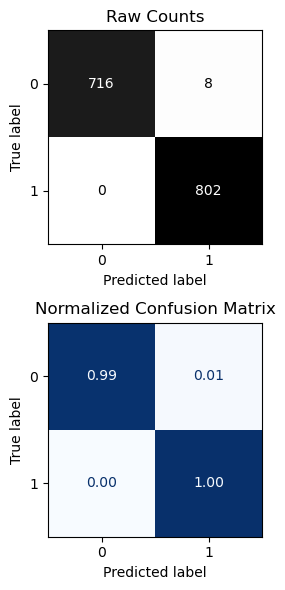


- Evaluating Test Data:
12/12 [==============================] - 1s 53ms/step - loss: 1.0363 - accuracy: 0.7194
{'loss': 1.036283254623413, 'accuracy': 0.7194444537162781}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       177
           1       0.72      0.74      0.73       183

    accuracy                           0.72       360
   macro avg       0.72      0.72      0.72       360
weighted avg       0.72      0.72      0.72       360



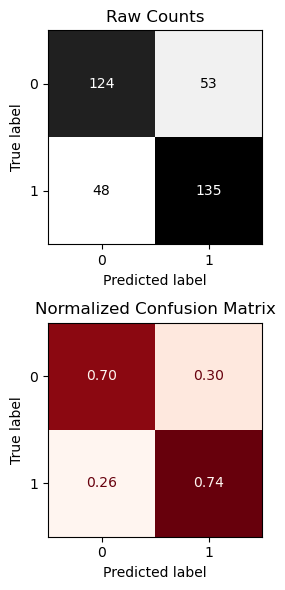

In [55]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    rnn_model2, X_train=train_ds, X_test=test_ds);

# With a simple tuning process, we found that the best model so far is using TF-IDF vectors and Logistic Regression. Further tuning can be performed to achieve better results.

In [56]:
# Saving model in tf format 
fpath_model = FPATHS['models']['deep']
tf.keras.models.save_model(rnn_model2, fpath_model, save_format='tf')

INFO:tensorflow:Assets written to: models/tf/assets


INFO:tensorflow:Assets written to: models/tf/assets


In [57]:
# Viewing the file contents of the saved model
sorted(os.listdir(fpath_model))

['assets',
 'fingerprint.pb',
 'keras_metadata.pb',
 'saved_model.pb',
 'variables']

In [58]:
# Saving the training dataset
fpath_save_train_ds = "Data/tf/train/"
# train_ds.save(path=fpath_save_train_ds)
tf.data.Dataset.save(train_ds, fpath_save_train_ds)
# Saving the validation dataset
fpath_save_val_ds = "Data/tf/val/"
tf.data.Dataset.save(val_ds, fpath_save_val_ds)
# Saving the test dataset
fpath_save_test_ds = "Data/tf/test/"
tf.data.Dataset.save(test_ds, fpath_save_test_ds)